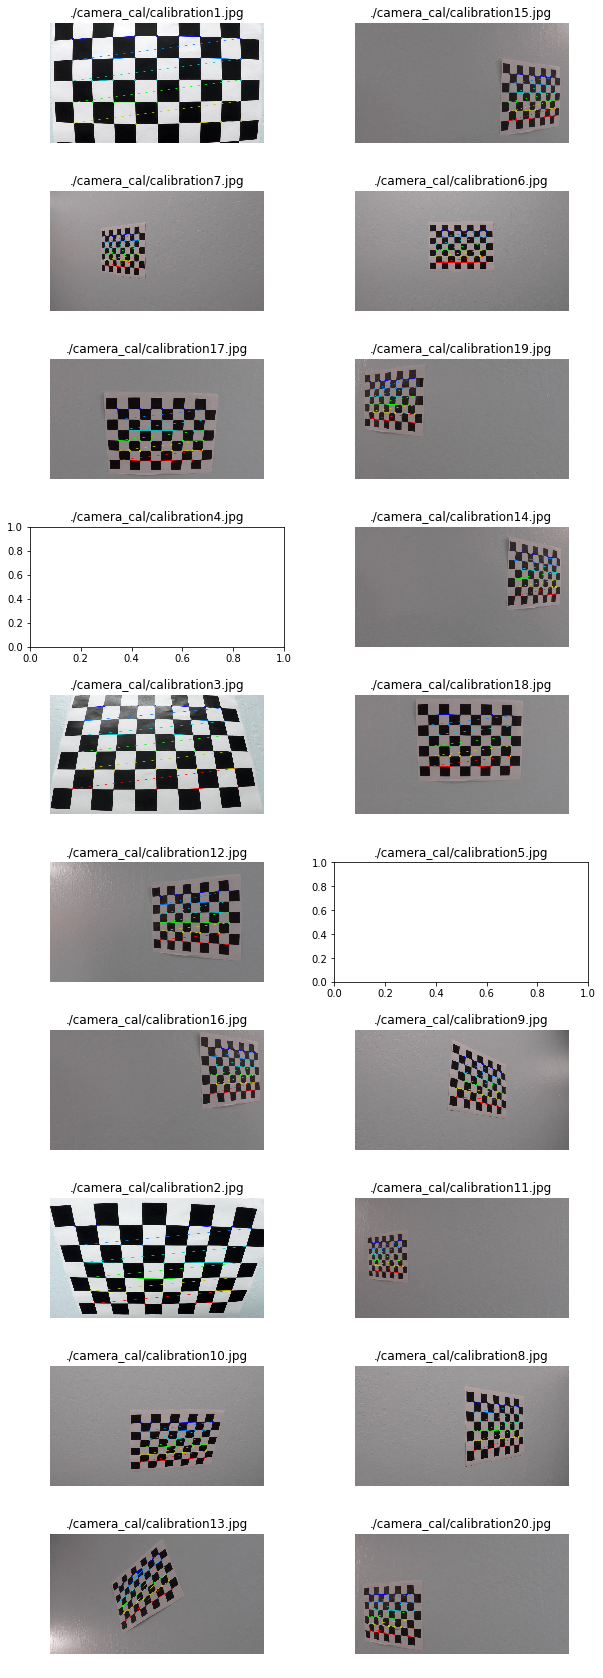

In [1]:

import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(10,2)
axs = axs.ravel()
fig.subplots_adjust(hspace = .4, wspace=.2)
fig.set_size_inches(10,30)

object_points = [] # 3d points in real world space
image_points = [] # 2d points in image plane.

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    nx,ny=9,6
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    if not ret == True:
        # some pictures do not have 9X6, try 9X5
        nx,ny=9,5
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        
    axs[i].set_title(fname)    
    if ret == True:
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        object_points.append(objp)
        image_points.append(corners)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)


True

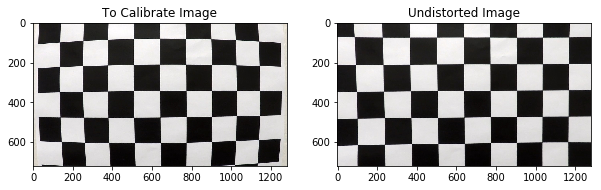

In [2]:
import os

srcimg = plt.imread(os.path.join('camera_cal', 'calibration1.jpg'))

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (img.shape[1], img.shape[0]), None,None)

undistorted_img = cv2.undistort(srcimg, mtx, dist)

def showDistortedImg(to_calibrate_img, undistorted_img):
    plt.figure(figsize=(10,40))
    plt.subplot(121)
    plt.imshow(to_calibrate_img)
    plt.title('To Calibrate Image')

    plt.subplot(122)
    plt.imshow(undistorted_img)
    plt.title('Undistorted Image')
    
showDistortedImg(srcimg, undistorted_img)

cv2.imwrite(os.path.join('output_images','undistorted_calib1.png'),undistorted_img)

In [3]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


In [4]:

def unwarp(img, src, dst):

    height,width = img.shape[:2]
    trans_matrix = cv2.getPerspectiveTransform(src, dst)
    inverse_matrix = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, trans_matrix, (width,height), flags=cv2.INTER_LINEAR)
    return warped, trans_matrix, inverse_matrix



In [5]:
# test unwarp method defined above by transferring and saving a test image.

def test_unwarp():
    srcImgPath = os.path.join('test_images', 'straight_lines1.jpg')
    srcimg = plt.imread(srcImgPath)
    img_undistort = undistort(srcimg)

    h,w = img.shape[:2]
    src = np.float32([(570,465),
                  (705,465), 
                  (250,685), 
                  (1040,685)])
    dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
    warped, _, _ = unwarp(img_undistort, src, dst)
    cv2.imwrite(os.path.join('output_images','straight1_warp.jpg'),warped)

    
test_unwarp()

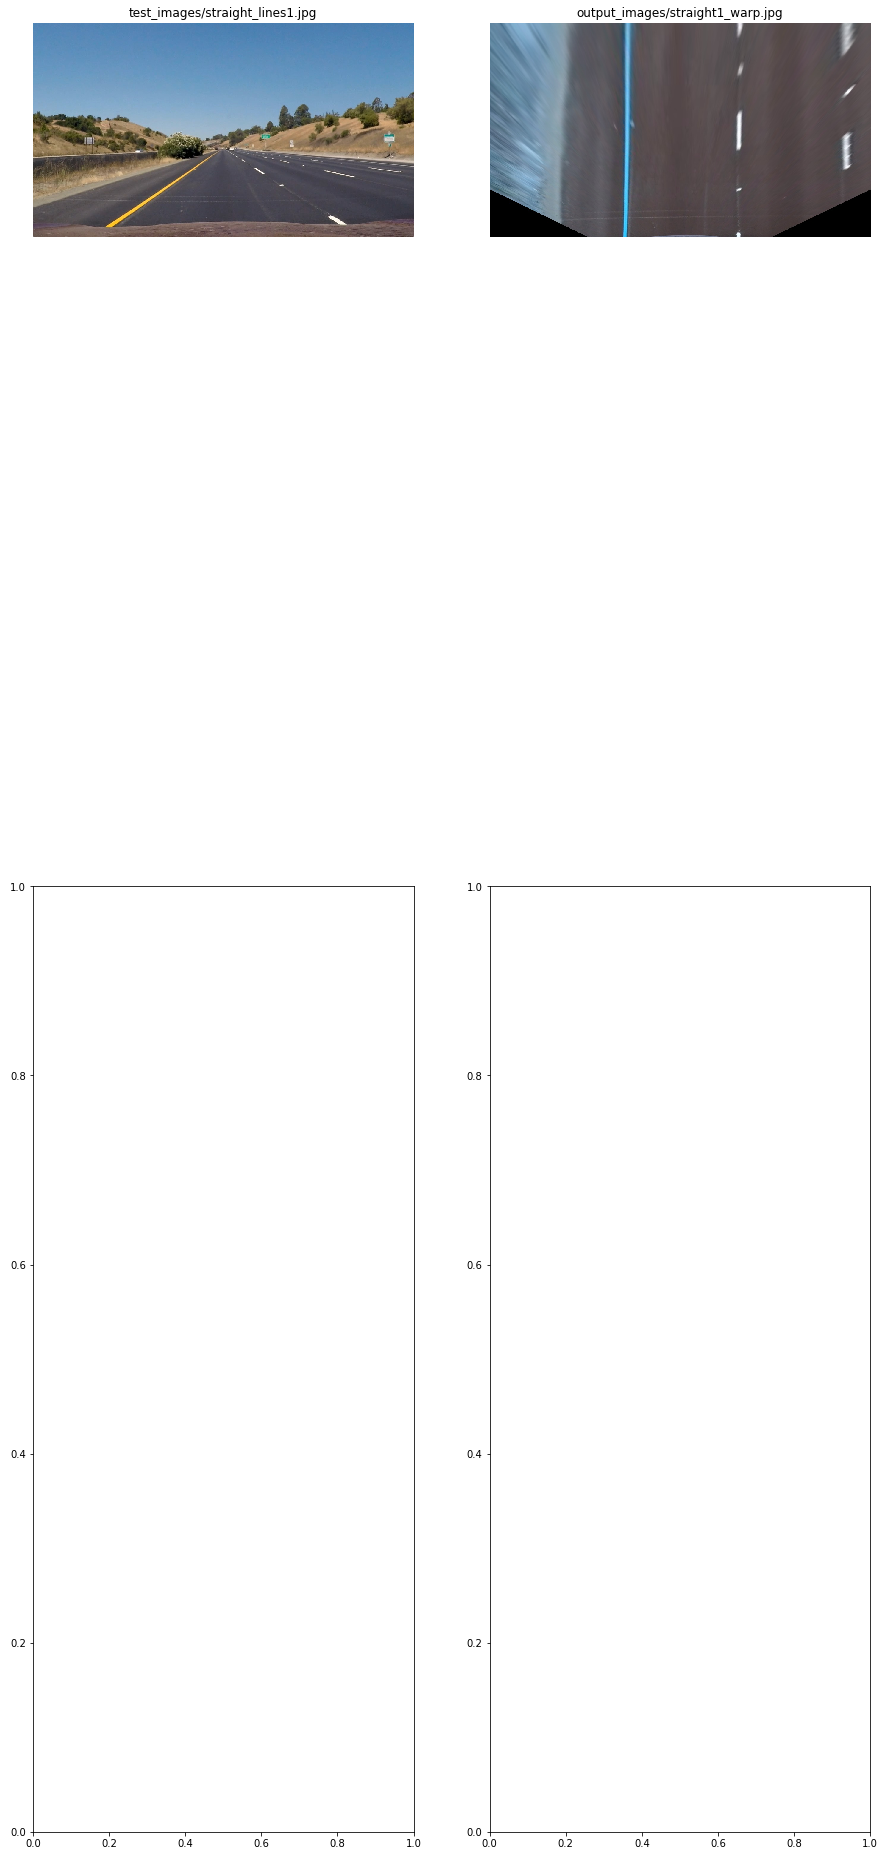

In [193]:
warp_compare = []
warp_compare.append(os.path.join('test_images', 'straight_lines1.jpg'))
warp_compare.append(os.path.join('output_images', 'straight1_warp.jpg'))

fig, axs = plt.subplots(len(warp_compare),2, figsize=(15, 40))
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()

i = 0
for imgfile in warp_compare:
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].set_title(imgfile)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1



In [162]:
# now pick two metrics from possible color spaces(RGB, HLS, LAB, etc) that can preserve as much as possible lane shapes, 
# while the noises were also reduced quite well

def dir_threshold(img, sobel_kernel=7, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output


def lab_bthresh(img, thresh=(190,255)):

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]

    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))

    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1

    return binary_output

def pipeline(img):
    # Undistort
    img_undistort = undistort(img)

    h,w = img.shape[:2]
    src = np.float32([(560,465),
                  (700,465), 
                  (240,695), 
                  (1040,695)])
    dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
    
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    '''    
    ksize = 3
    mag_binary = mag_thresh(img_unwarp)
    dir_binary = dir_threshold(img_unwarp, thresh=(0, 0.1))
    combined = np.zeros_like(dir_binary)
    combined[(mag_binary == 1) & (dir_binary == 1)] = 1
    '''

    '''
    img_mag = mag_thresh(img_unwarp)
    img_labb = lab_bthresh(img_unwarp)
    combined = np.zeros_like(img_mag)
    combined[ (img_mag == 1) | (img_labb == 1)] = 1
    '''
    
    '''
    img_mag = mag_thresh(img_unwarp)
    img_abs = abs_sobel_thresh(img_unwarp)    
    combined = np.zeros_like(img_mag)
    combined[ (img_mag == 1) | (img_abs == 1)] = 1
    '''
    img_mag = mag_thresh(img_unwarp)
    img_labb = lab_bthresh(img_unwarp)
    img_abs_sobel = abs_sobel_thresh(img_unwarp)
    
    combined = np.zeros_like(img_mag)
    combined[ ((img_mag == 1) | (img_labb == 1)) & (img_abs_sobel == 1) ] = 1
    return combined, Minv



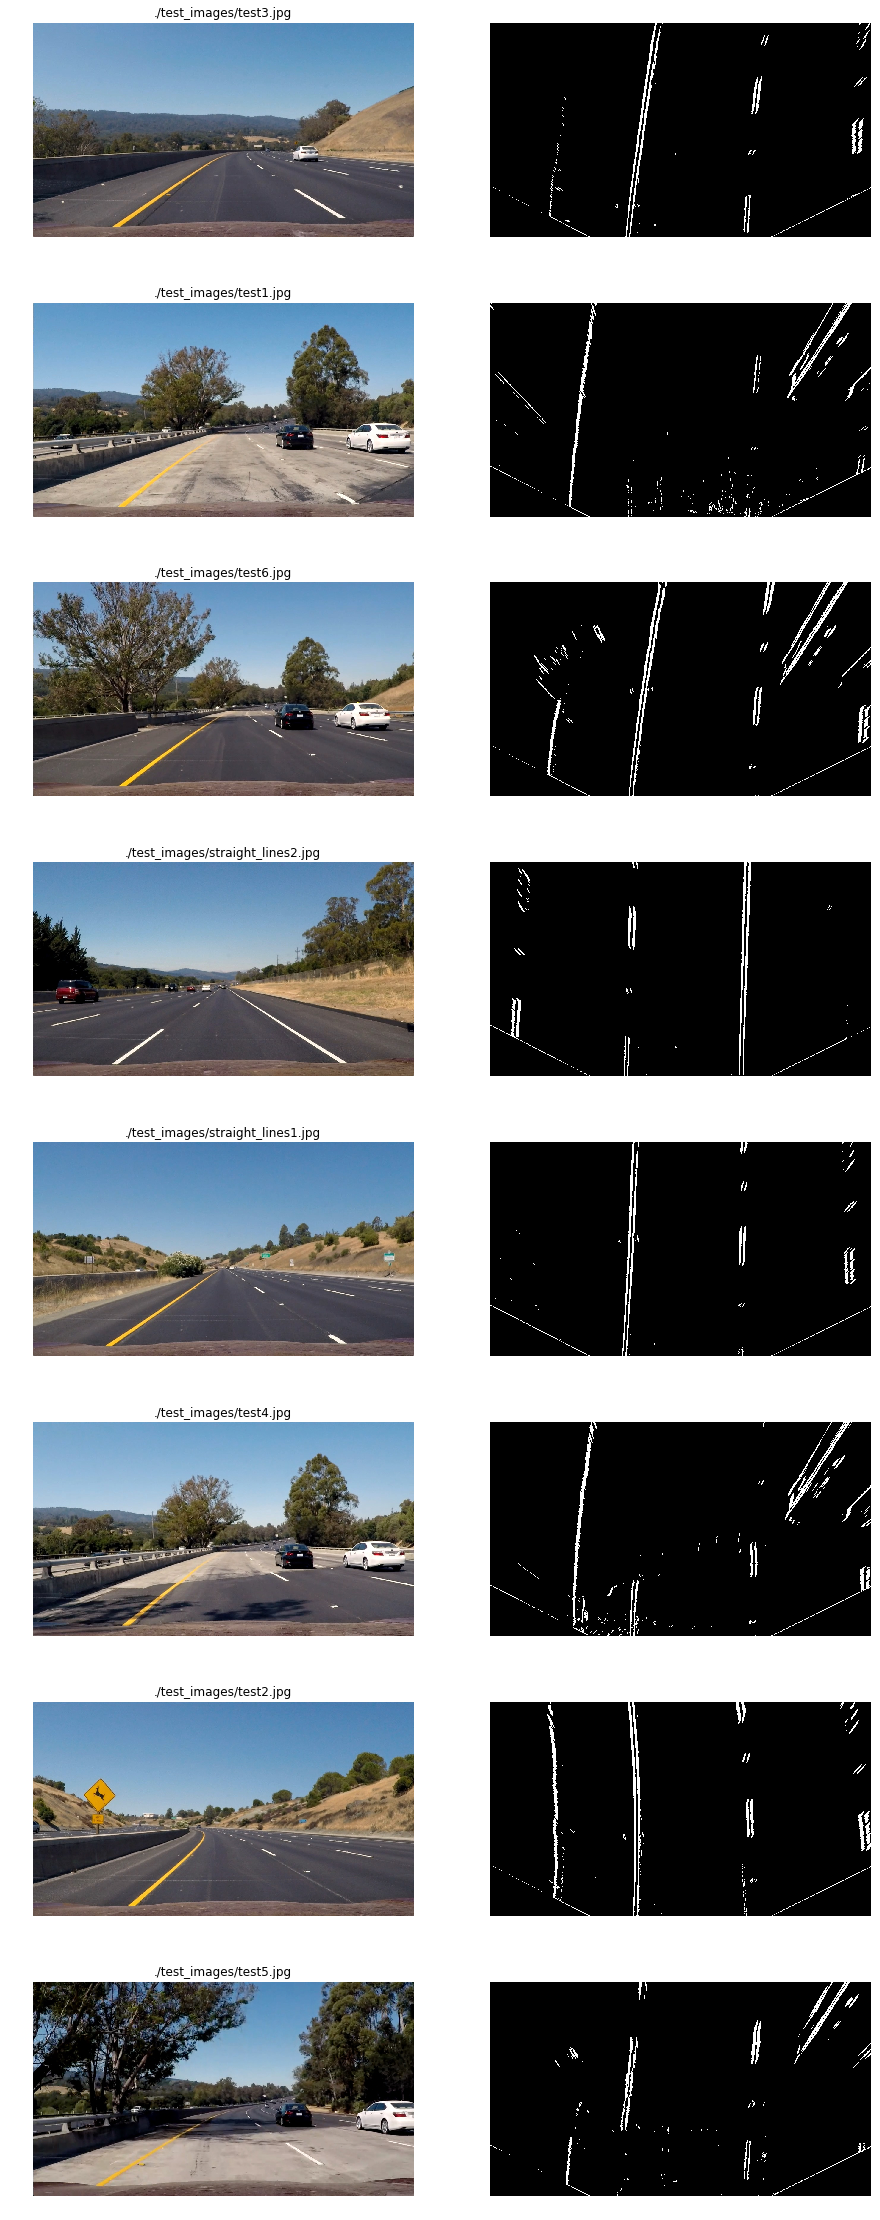

In [163]:
images = glob.glob('./test_images/*.jpg')
                            
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(15, 40))
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()

i = 0
for imgfile in images:
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i].set_title(imgfile)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1


def test_pipeline():
    srcImgPath = os.path.join('test_images', 'straight_lines1.jpg')
    srcimg = plt.imread(srcImgPath)
    img_pipelined, _ = pipeline(srcimg)

    cv2.imwrite(os.path.join('output_images','straight1_pipelined.jpg'), img_pipelined)

    
test_pipeline()

In [164]:
def polyfit_windows(img, l_fit_prev =None, r_fit_prev = None):
    non = img.nonzero()
    nony = np.array(non[0])
    nonx = np.array(non[1])
    margin = 80
    
    #if we have prev fits for both left and right lanes
    if l_fit_prev is not None and r_fit_prev is not None:
        #for left lane, get the non-zero points' indice within a margin of previous fit
        l_lane_inds = ((nonx > (l_fit_prev[0]*(nony**2) + l_fit_prev[1]*nony + l_fit_prev[2] - margin)) & 
                      (nonx < (l_fit_prev[0]*(nony**2) + l_fit_prev[1]*nony + l_fit_prev[2] + margin))) 

        #for right lane, get the non-zero points' indice within a margin of previous fit
        r_lane_inds = ((nonx > (r_fit_prev[0]*(nony**2) + r_fit_prev[1]*nony + r_fit_prev[2] - margin)) & 
                       (nonx < (r_fit_prev[0]*(nony**2) + r_fit_prev[1]*nony + r_fit_prev[2] + margin)))  

        # Extract left and right line pixel positions
        lx = nonx[l_lane_inds]
        ly = nony[l_lane_inds] 
        rx = nonx[r_lane_inds]
        ry = nony[r_lane_inds]
    
        l_fit_new, r_fit_new = (None, None)
        if len(lx) != 0:
            # Fit a second order polynomial to each
            l_fit_new = np.polyfit(ly, lx, 2)
        if len(rx) != 0:
            r_fit_new = np.polyfit(ry, rx, 2)
        return l_fit_new, r_fit_new, l_lane_inds, r_lane_inds

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)

    lx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

    # Number of sliding windows is 10
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    # Current positions to be updated for each window
    lx_current = lx_base
    rx_current = rx_base

    # minimum number of pixels found to recenter window
    minpix = 40
    # left and right lane pixel indices
    l_lane_inds = []
    r_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows
    for window in range(nwindows):
        # window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = lx_current - margin
        win_xleft_high = lx_current + margin
        win_xright_low = rx_current - margin
        win_xright_high = rx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # the nonzero pixels in x and y within the window
        l_inds = ((nony >= win_y_low) & (nony < win_y_high) & (nonx >= win_xleft_low) & (nonx < win_xleft_high)).nonzero()[0]
        r_inds = ((nony >= win_y_low) & (nony < win_y_high) & (nonx >= win_xright_low) & (nonx < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        l_lane_inds.append(l_inds)
        r_lane_inds.append(r_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(l_inds) > minpix:
            lx_current = np.int(np.mean(nonx[l_inds]))
        if len(r_inds) > minpix:        
            rx_current = np.int(np.mean(nonx[r_inds]))

    # Concatenate the arrays of indices
    l_lane_inds = np.concatenate(l_lane_inds)
    r_lane_inds = np.concatenate(r_lane_inds)

    lx = nonx[l_lane_inds]
    ly = nony[l_lane_inds] 
    rx = nonx[r_lane_inds]
    ry = nony[r_lane_inds]
        
    l_fit, r_fit = (None, None)

    if len(lx) != 0:
        l_fit = np.polyfit(ly, lx, 2)
    if len(rx) != 0:
        r_fit = np.polyfit(ry, rx, 2)
    
    return l_fit, r_fit, l_lane_inds, r_lane_inds

In [165]:
def get_radius_and_distance(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_curverad, right_curverad, center_dist = (0, 0, 0)

    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # (lx, ly), (rx, ry)
    lx = nonzerox[l_lane_inds]
    ly = nonzeroy[l_lane_inds] 
    rx = nonzerox[r_lane_inds]
    ry = nonzeroy[r_lane_inds]
    
    if len(lx) != 0 and len(rx) != 0:
        l_fit_cr = np.polyfit(ly*ym_per_pix, lx*xm_per_pix, 2)
        r_fit_cr = np.polyfit(ry*ym_per_pix, rx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        l_curverad = ((1 + (2*l_fit_cr[0]*y_eval*ym_per_pix + l_fit_cr[1])**2)**1.5) / np.absolute(2*l_fit_cr[0])
        r_curverad = ((1 + (2*r_fit_cr[0]*y_eval*ym_per_pix + r_fit_cr[1])**2)**1.5) / np.absolute(2*r_fit_cr[0])
    
    # Distance to center is mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return l_curverad, r_curverad, center_dist

In [166]:
def drawLane(img):
    rgbimg, ret = drawLane2(img)
    return ret

# we keep one previous fit, if we could not find fit on current image, we use previous fit
def drawLane2(img):
    global prev_l_fit
    global prev_r_fit
    
    new_img = np.copy(img)
    rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bin_img, Minv = pipeline(rgbimg)

    l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_windows(bin_img)
    
    #print(l_fit, r_fit, prev_l_fit, prev_r_fit)
    if not l_fit == None and not r_fit == None:
        prev_l_fit, prev_r_fit = l_fit, r_fit
        
    if l_fit == None or r_fit == None:
        if prev_l_fit == None or prev_r_fit == None:
            # we don't have current or previous fit, so we don't draw anything on image
            return rgbimg, rgbimg
        
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_windows(bin_img, prev_l_fit, prev_r_fit)

        if not l_fit == None and not r_fit == None:
            prev_l_fit, prev_r_fit = l_fit, r_fit
        else:
            l_fit, r_fit = prev_l_fit, prev_r_fit
    
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = bin_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # warp back to original image space using inverse matrix (Minv) we got in pipeline(when we do unwarp)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # combine the result with the original image
    result = cv2.addWeighted(rgbimg, 1, newwarp, 0.5, 0)
    
    rad_l, rad_r, d_center = get_radius_and_distance(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds)
    
    abs_d_center = np.absolute(d_center)
    if d_center < 0:
        direction = "left"
    else:
        direction = "right"
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius: ' + '{:04.2f}'.format((rad_l+rad_r)/2) + 'm'
    cv2.putText(result, text, (40,80), font, 2, (220,220,100), 2, cv2.LINE_AA)
    text = '{:04.3f}'.format(abs_d_center) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,160), font, 2, (220,220,100), 2, cv2.LINE_AA)
    
    return rgbimg, result

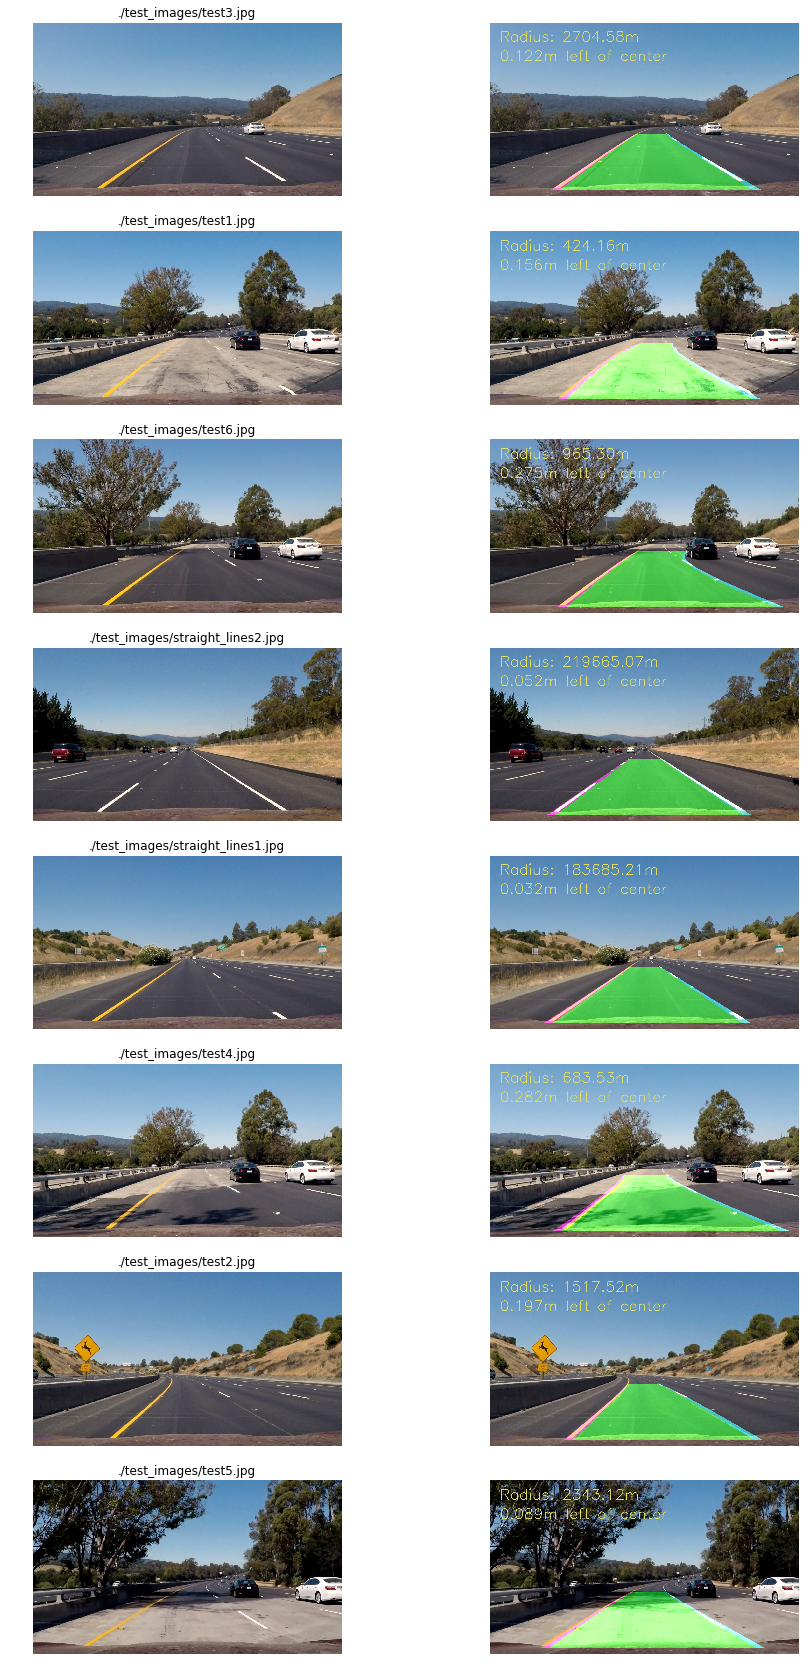

In [167]:
prev_l_fit = None
prev_r_fit = None

images = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(len(images),2, figsize=(15, 30))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

i = 0
for imgfile in images:
    img = cv2.imread(imgfile)
    rgbimg, out = drawLane2(img)
    axs[i].set_title(imgfile)
    axs[i].imshow(rgbimg)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(out)
    axs[i].axis('off')
    i += 1


In [168]:
import os
from moviepy.editor import VideoFileClip

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, 't{}.png'.format(t))
        clip.save_frame(imgpath, t)

movie = 'project_video.mp4'
imgdir = 'video_imgs'
times = [0.5, 4.5,  8.5, 12.5, 16.5, 20.5, 24.5, 28.5, 32.5, 36.5]

extract_frames(movie, times, imgdir)

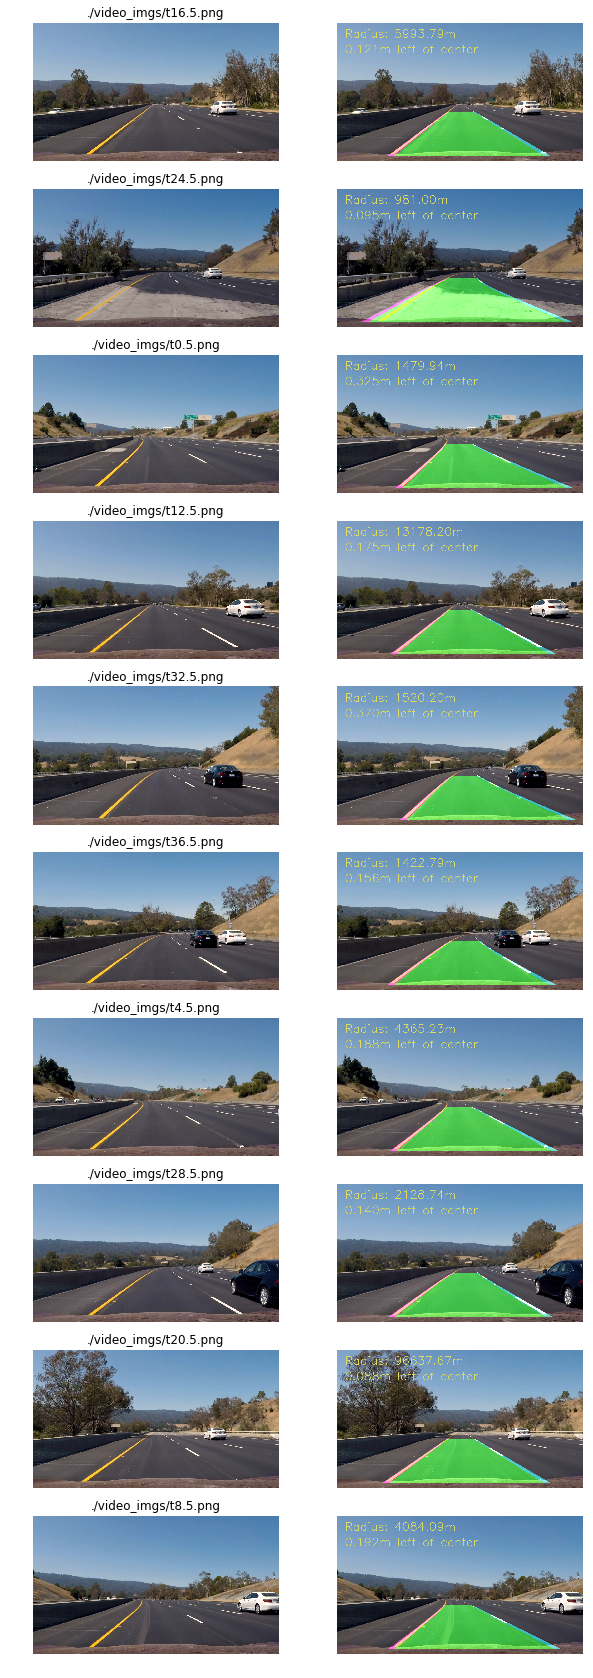

In [169]:
images = glob.glob('./video_imgs/*.png')
fig, axs = plt.subplots(len(images),2, figsize=(10, 30))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

i = 0
for imgfile in images:
    img = cv2.imread(imgfile)
    rgbimg, out = drawLane2(img)
    axs[i].set_title(imgfile)
    axs[i].imshow(rgbimg)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(out)
    axs[i].axis('off')
    i += 1


In [15]:

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(drawLane)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  6.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min, sys: 10.5 s, total: 3min 11s
Wall time: 3min 3s


In [185]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None

    def add(self, fit, inds):
        # add a found fit to the line, up to MAX_FIT
        MAX_FIT = 10
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit diffs
                self.diffs = abs(fit-self.best_fit)

                if (abs(self.diffs[1] - self.best_fit[1]) > 0.5 \
                    or abs(self.diffs[2] - self.best_fit[2]) > 100) \
                    and len(self.current_fit) > 0:
                    self.detected = False
                    self.current_fit.pop(0)
                else: # the new coming fit is within range, so save it and update best_fit
                    self.detected = True
                    self.px_count = np.count_nonzero(inds)
                    self.current_fit.append(fit)
                    if len(self.current_fit) > MAX_FIT:
                        # throw out old fits, keep newest n
                        self.current_fit = self.current_fit[len(self.current_fit)-MAX_FIT:]
                    self.best_fit = np.average(self.current_fit, axis=0)
            else: # no best_fit yet
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                self.best_fit = fit
        # else fit is None, remove one from the history
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit.pop(0)
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
                

In [186]:
# We use Line class to preserve more (up to MAX_FIT) previous fits, then for current image, 
# the algorithm is going to compute a "best fit" instead of current fit. This way provides
# more resiliency to missing line detection in some frameworks.
def drawLane3(img, img_bin, l_fit, r_fit, l_lane_inds, r_lane_inds, Minv):
    new_img = np.copy(img)
    if l_fit is None or r_fit is None:
        return img

    warp_zero = np.zeros_like(img_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    h,w = img_bin.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 

    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    rad_l, rad_r, d_center = get_radius_and_distance(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
    abs_d_center = np.absolute(d_center)
    if d_center < 0:
        direction = "left"
    else:
        direction = "right"
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius: ' + '{:04.2f}'.format((rad_l+rad_r)/2) + 'm'
    cv2.putText(result, text, (40,80), font, 2, (220,220,100), 2, cv2.LINE_AA)
    text = '{:04.3f}'.format(abs_d_center) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,160), font, 2, (220,220,100), 2, cv2.LINE_AA)
    
    return result

In [187]:
def processImage(img):
    rgb, out = processImage2(img)
    return out

def processImage2(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(new_img)
    
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_windows(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_windows(img_bin, l_line.best_fit, r_line.best_fit)
        
    if l_fit is not None and r_fit is not None:
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None

    l_line.add(l_fit, l_lane_inds)
    r_line.add(r_fit, r_lane_inds)

    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out = drawLane3(new_img, img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds, Minv)
    else:
        img_out = new_img
    img_out = cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR)

    return new_img, img_out


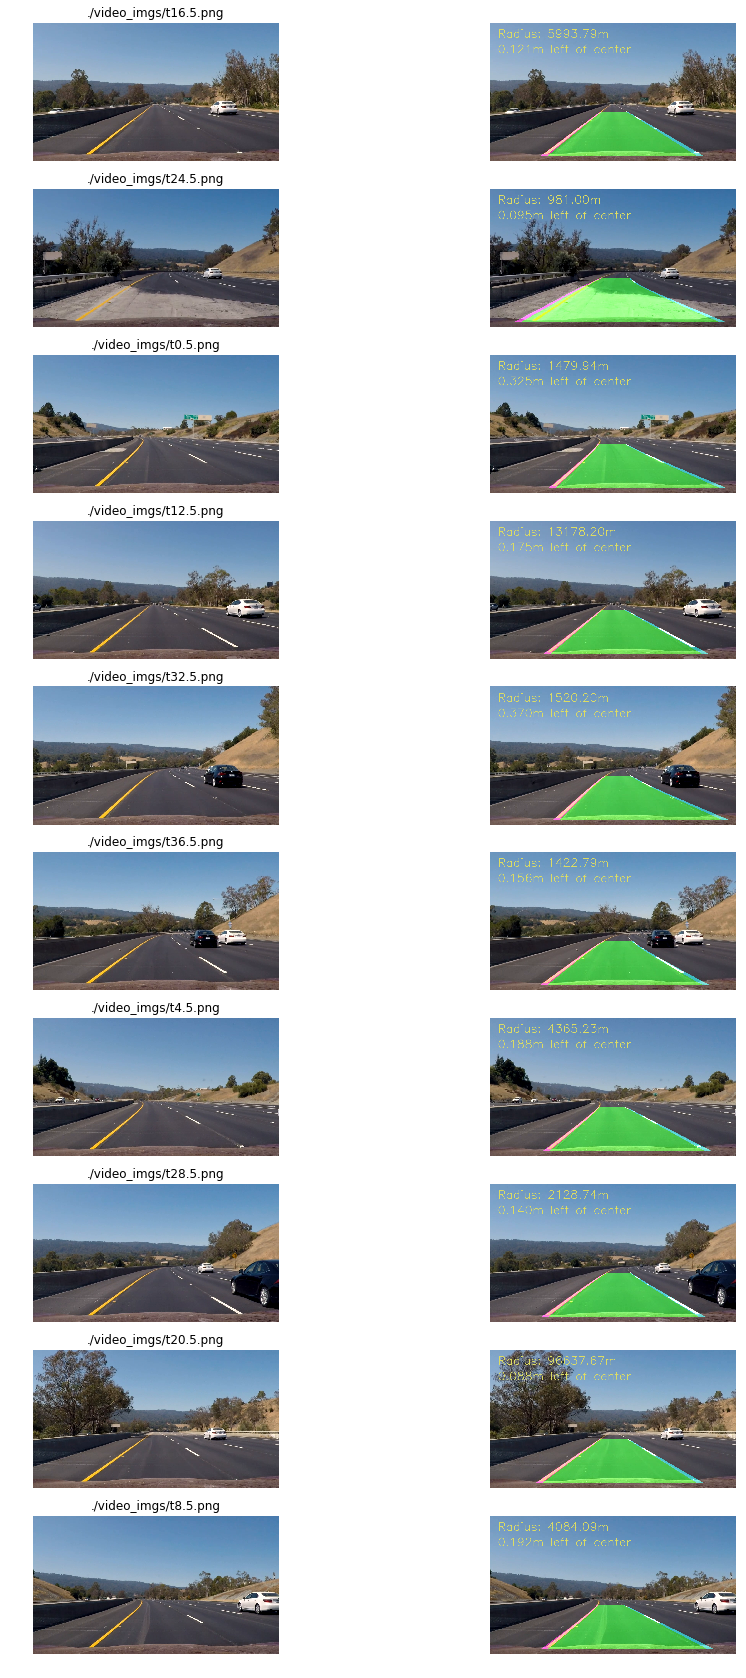

In [188]:
images = glob.glob('./video_imgs/*.png')
fig, axs = plt.subplots(len(images),2, figsize=(15, 30))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

i = 0
for imgfile in images:
    img = cv2.imread(imgfile)
    rgbimg, out = drawLane2(img)
    axs[i].set_title(imgfile)
    axs[i].imshow(rgbimg)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(out)
    axs[i].axis('off')
    i += 1

In [189]:
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output2.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(processImage)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [05:43<00:00,  3.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 5min 59s, sys: 2.18 s, total: 6min 1s
Wall time: 5min 45s


In [64]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(processImage)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:59<00:00,  8.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 2s, sys: 1.64 s, total: 1min 4s
Wall time: 1min


In [65]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'harder_challenge_video_output.mp4'
video_input1 = VideoFileClip('harder_challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(processImage)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:00<00:00,  7.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 2s, sys: 5.04 s, total: 3min 7s
Wall time: 3min 2s
